In [4]:
import scanpy as sc 
import os 
import matplotlib.pyplot as plt
import pandas as pd

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


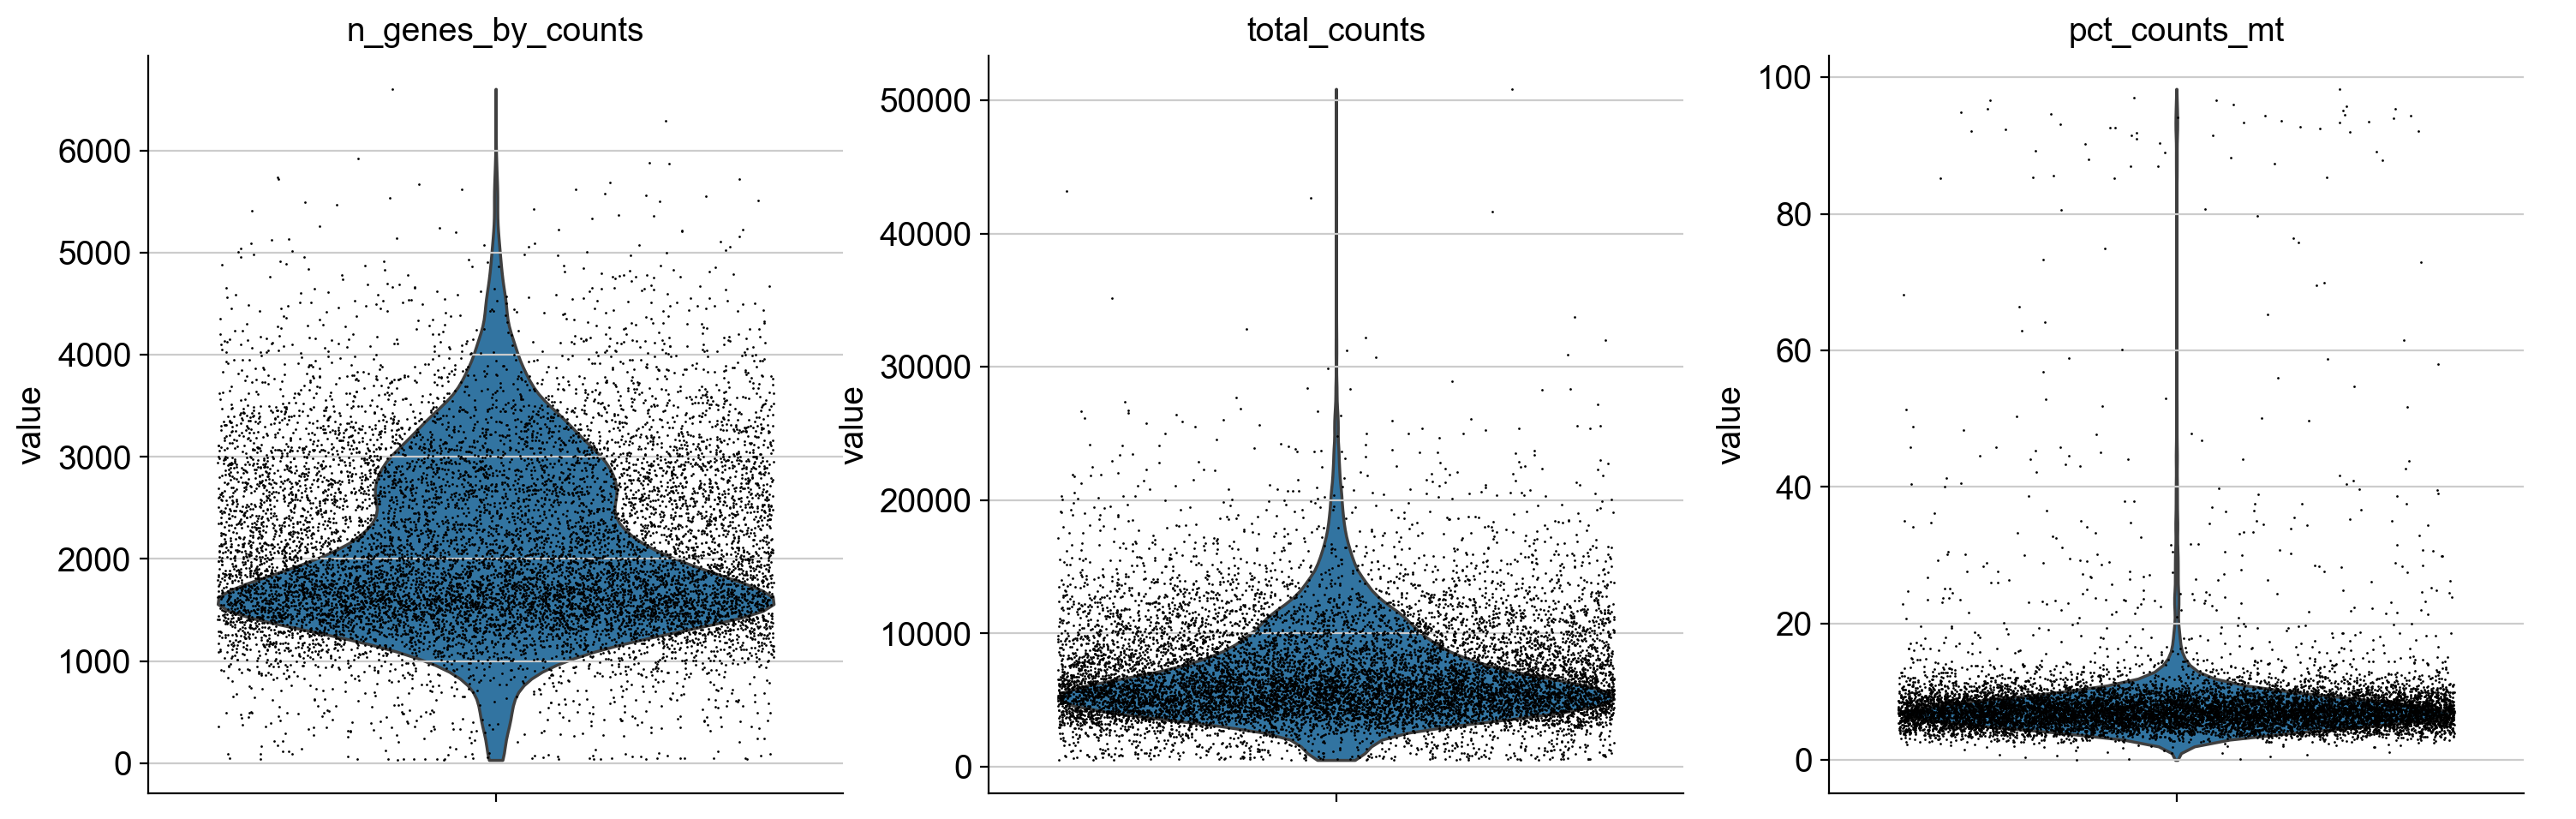

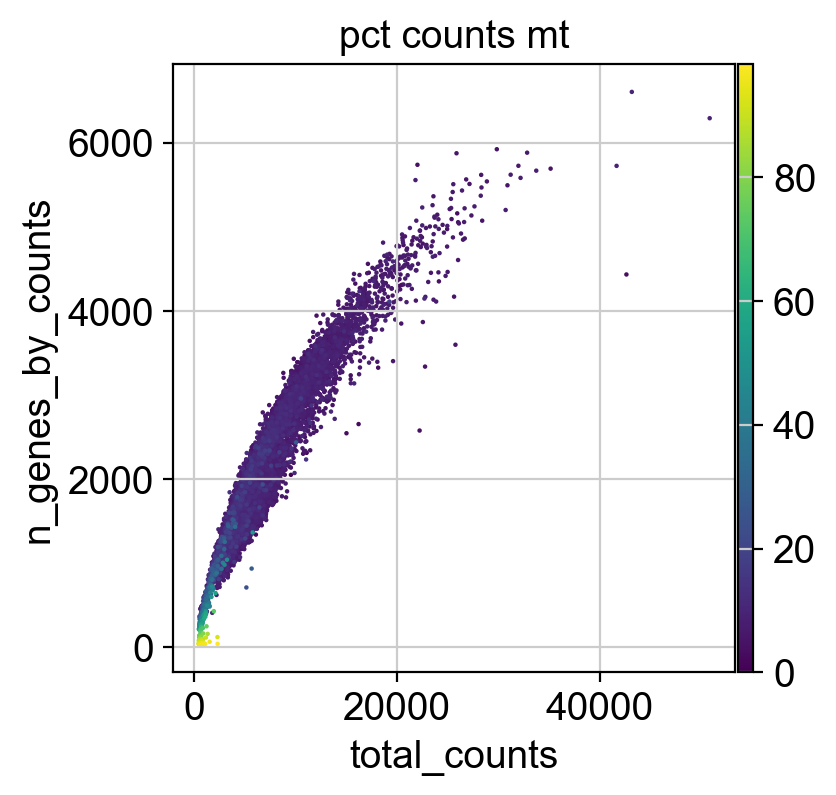

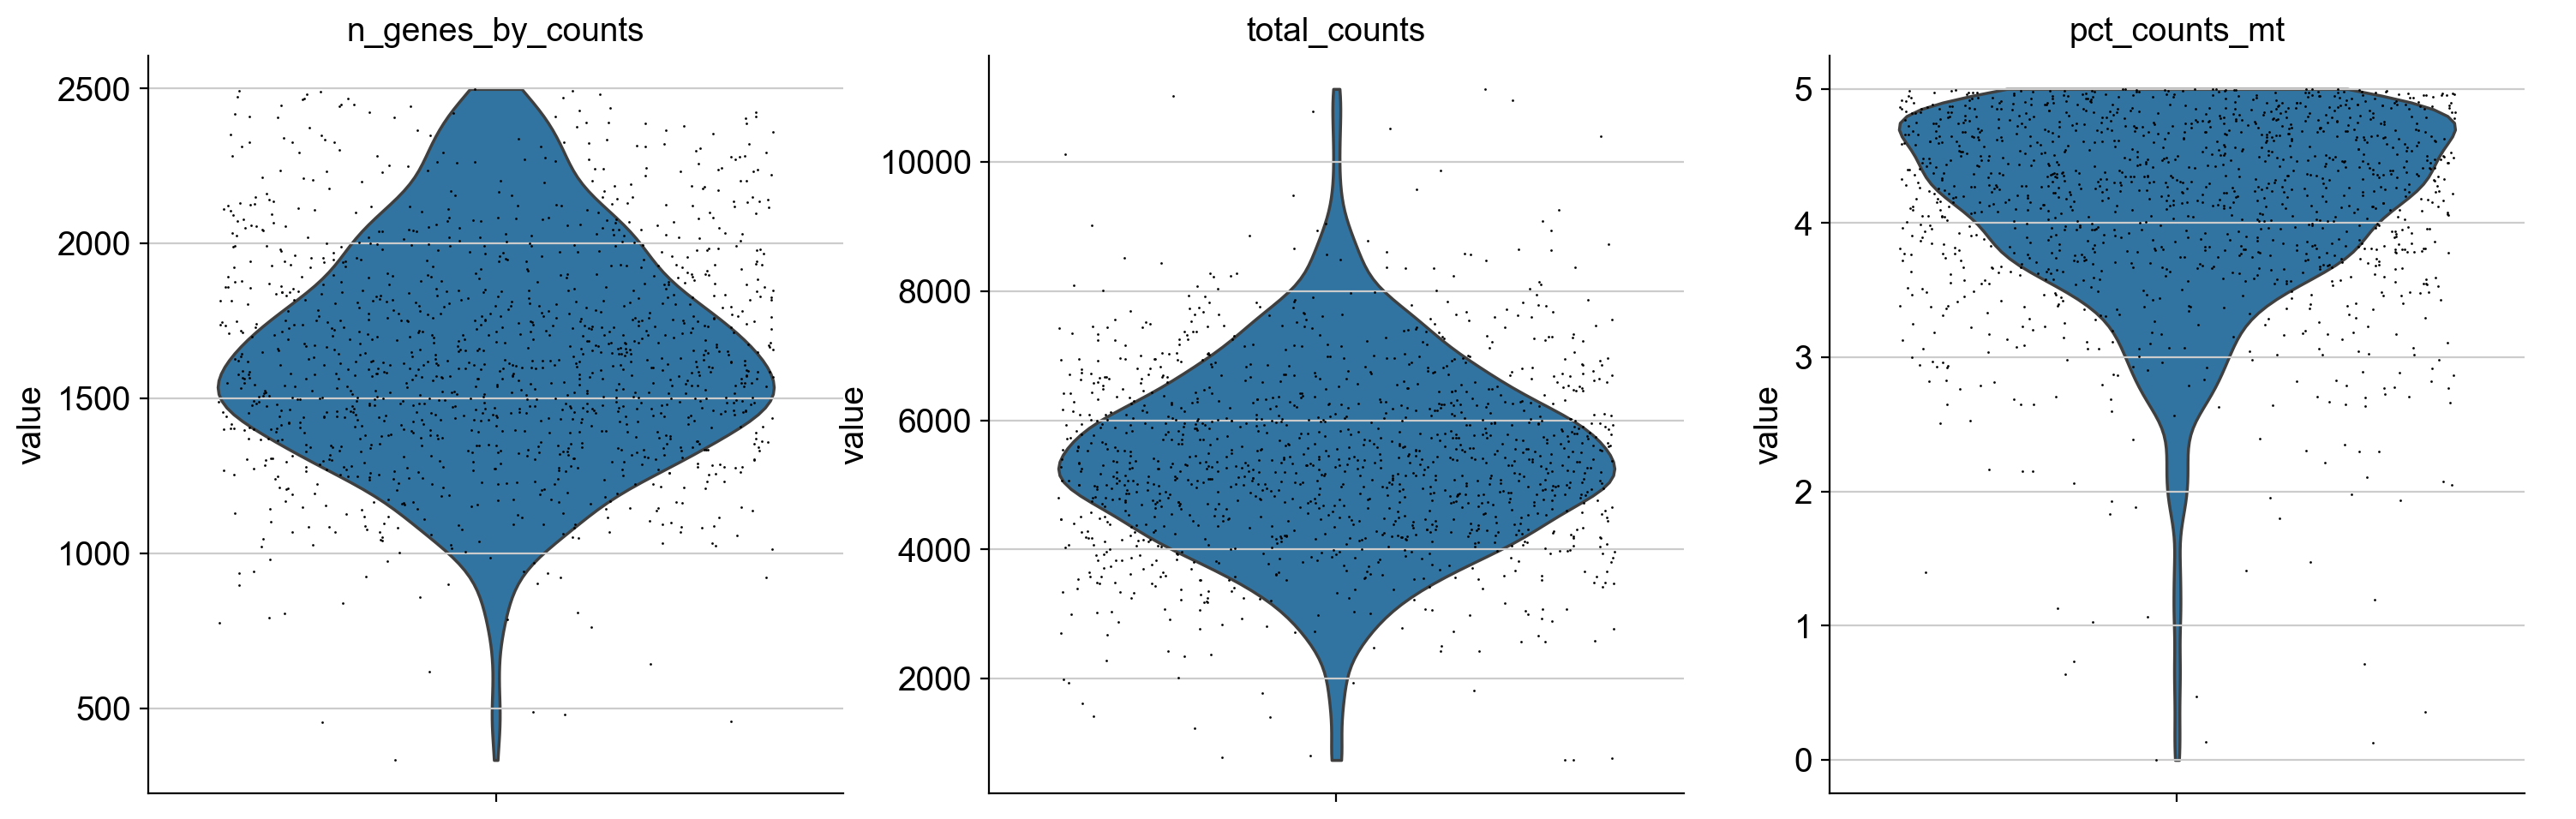

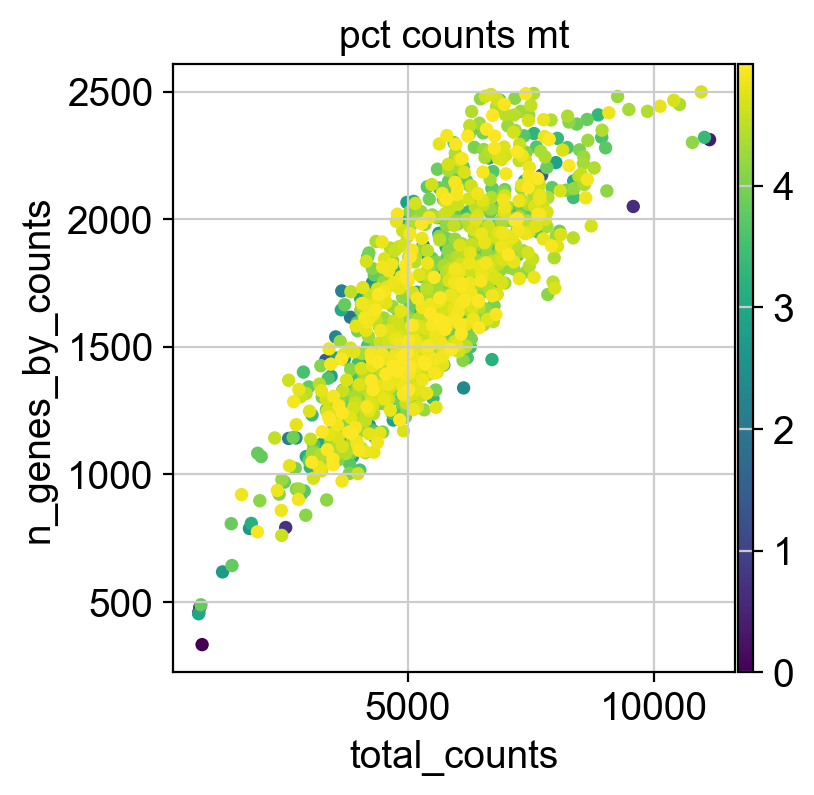

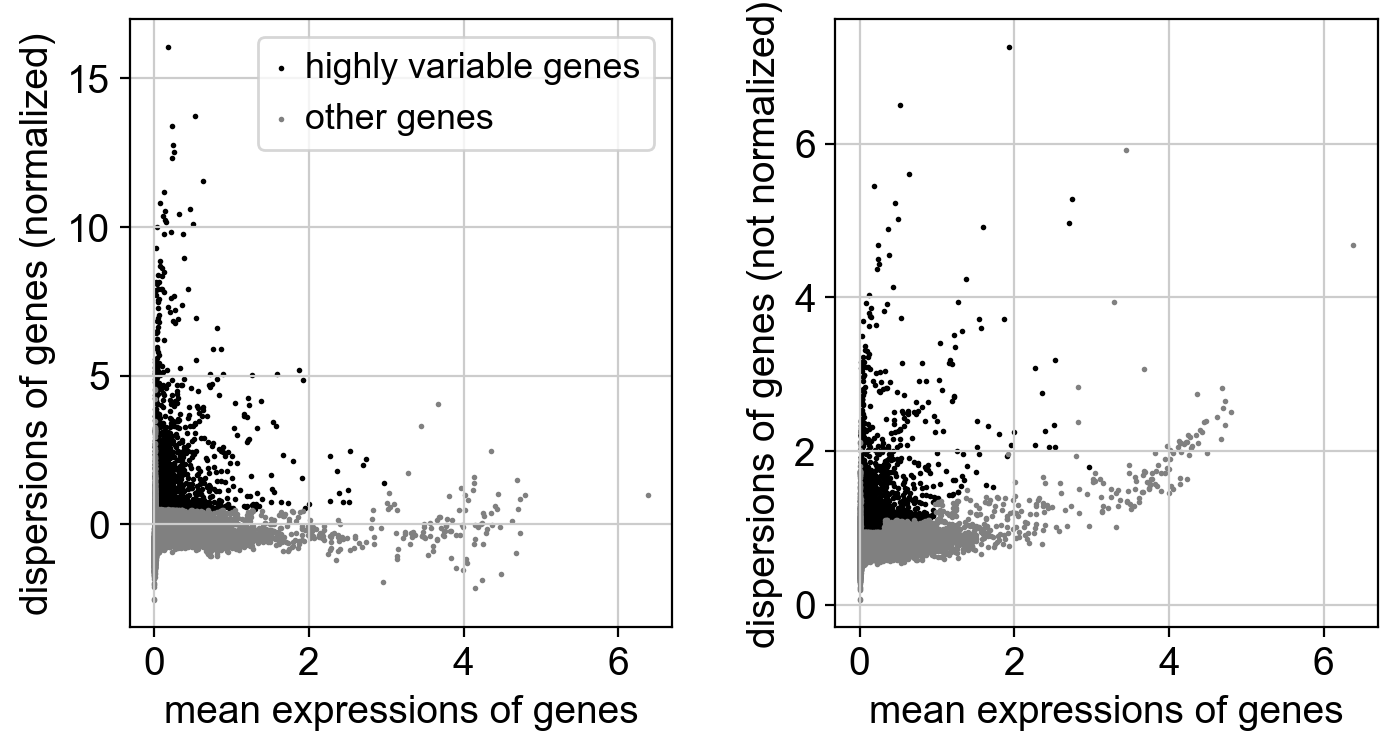

Preprocessing complete.


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [5]:

import scanpy as sc

import os

# Configuration
sc.set_figure_params(dpi=100, facecolor='white', frameon=False)
sc.settings.verbosity = 0 # Silent
plot_output_folder = "C:/Users/Admin/Desktop/scRNA_analysis/plots/preprocessing"
os.makedirs(plot_output_folder, exist_ok=True)
sc.settings.figdir = plot_output_folder

#Data file path
data_file_path = "C:/Users/Admin/Desktop/Cell Matrix.h5"

#Loading the Data
adata = sc.read_10x_h5(data_file_path)
adata.var_names_make_unique()

#Calculating Metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

#Visualizing Metrics (Pre-filtering) - Plots saved to 'figdir'
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save="_qc_violin_pre.png")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', save="_qc_scatter_pre.png")

#Filtering Cells and Genes
adata = adata[
    (adata.obs['n_genes_by_counts'] > 200) &
    (adata.obs['n_genes_by_counts'] < 2500) &
    (adata.obs['pct_counts_mt'] < 5.0)
].copy()
sc.pp.filter_genes(adata, min_cells=3)

#Visualizing Metrics (Post-filtering) - Plots saved to 'figdir'
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save="_qc_violin_post.png")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt', save="_qc_scatter_post.png")

#Normalization and Log-transformation
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

#Identifying Highly Variable Genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata, save="_highly_variable_genes.png")
adata = adata[:, adata.var.highly_variable].copy()

#Scaling the Data
sc.pp.scale(adata, max_value=10)
print("Preprocessing complete.")

  



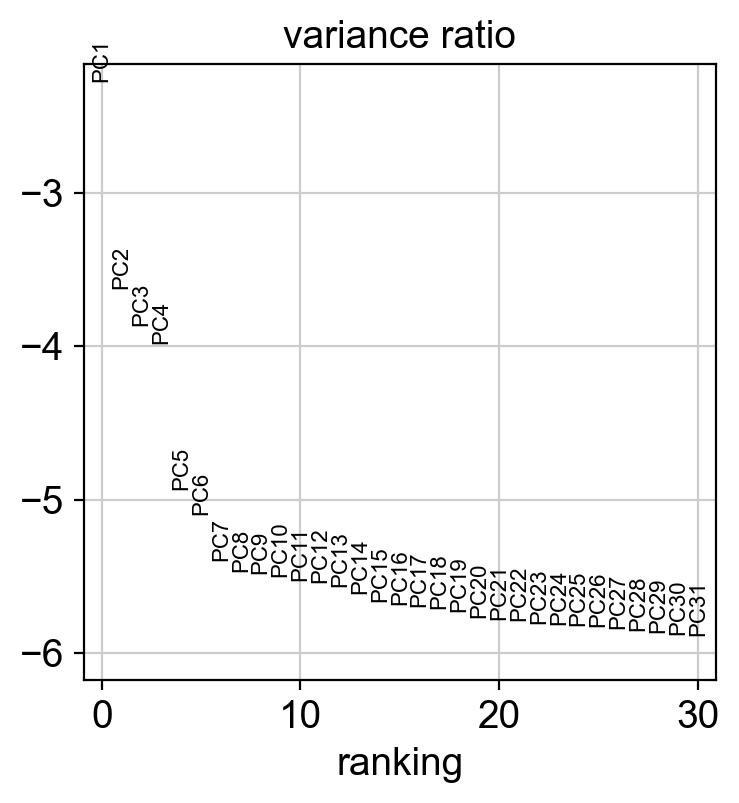

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


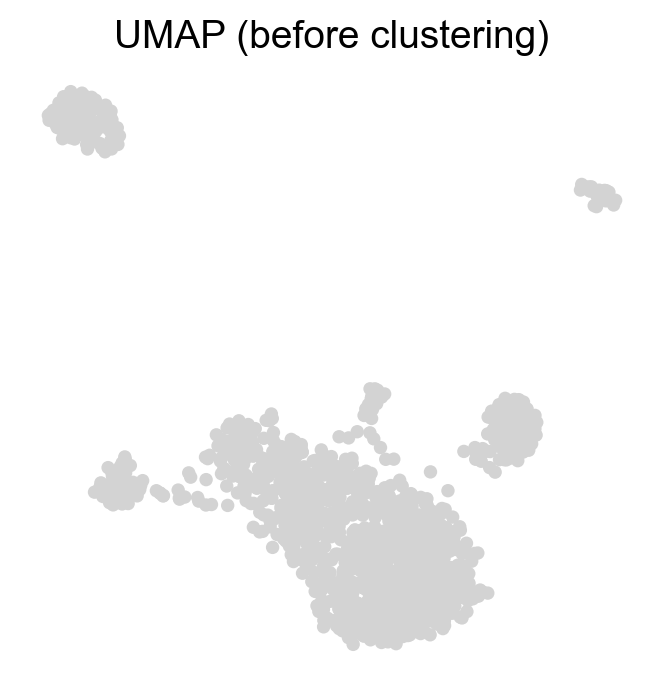

C:\Users\Admin\AppData\Local\Temp\ipykernel_5332\2964518910.py:16: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


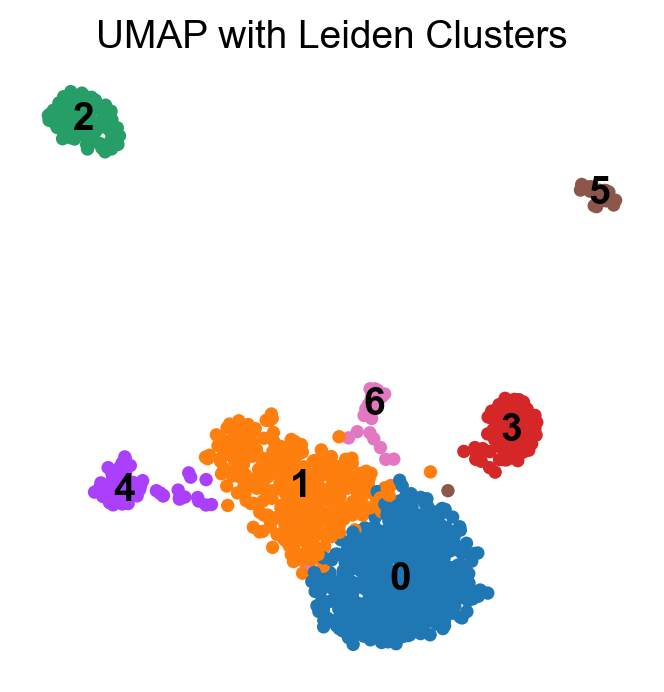

Dimensionality Reduction and Clustering Complete.


In [6]:
#2. UMAP and Leiden Clustering

save_file_path = "C:/Users/Admin/Desktop/UMAP and Clustering Plots"
# A. Principal Component Analysis (PCA)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, save="_pca_variance_ratio.png") #Elbow Plot

# B. Computing the Nearest-Neighbour Graph
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

# C. UMAP Embedding
sc.tl.umap(adata)
sc.pl.umap(adata, save="_umap_initial.png", title="UMAP (before clustering)")

# D. Leiden Clustering
sc.tl.leiden(adata, resolution=0.5)

# E. Visualizing UMAP with Clusters
sc.pl.umap(adata, color='leiden', legend_loc='on data', save="_umap_leiden.png", title="UMAP with Leiden Clusters")
print("Dimensionality Reduction and Clustering Complete.")


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: inv


Diagnostic: Actual Leiden Cluster Categories
Actual Leiden clusters are: ['0', '1', '2', '3', '4', '5', '6']
End Diagnostic


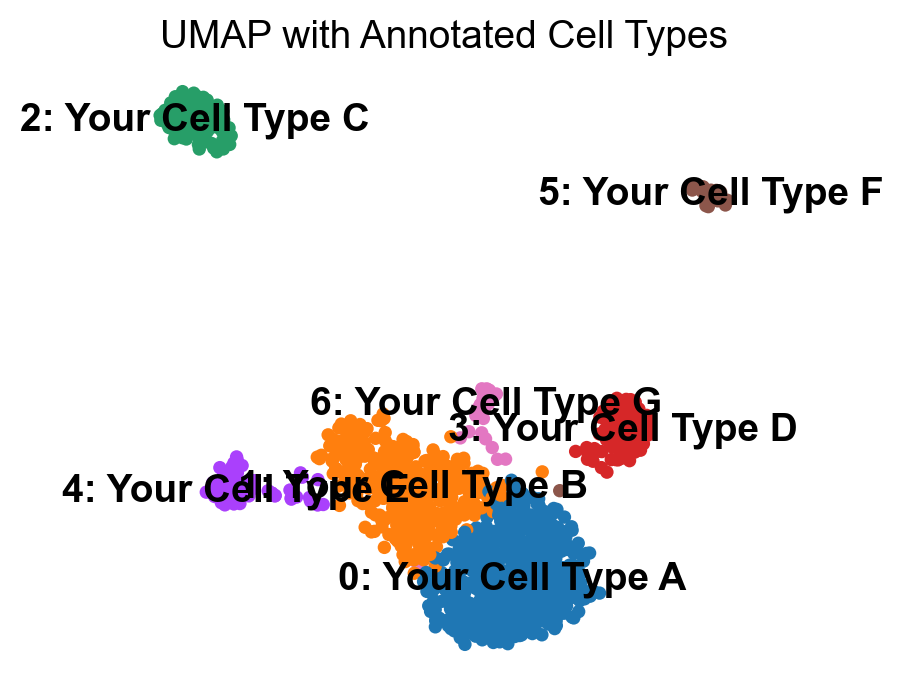

Marker gene finding and cluster annotation complete (review plots and manual names).


In [7]:
#3 Finding the Clusters in the data and naming them 
# Ensure rank_genes_groups has run from step 4
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', rankby_abs=True, tie_correct=True)

# Diagnostic: Print the actual categories
print("\nDiagnostic: Actual Leiden Cluster Categories")
actual_leiden_categories = adata.obs['leiden'].cat.categories.tolist()
print(f"Actual Leiden clusters are: {actual_leiden_categories}")
print("End Diagnostic")

new_cluster_names = [
    "0: Your Cell Type A",
    "1: Your Cell Type B",
    "2: Your Cell Type C", 
    "3: Your Cell Type D",
    "4: Your Cell Type E",
    "5: Your Cell Type F",
    "6: Your Cell Type G"
]

adata.rename_categories('leiden', new_cluster_names) 
sc.pl.umap(adata, color='leiden', legend_loc='on data', save="_umap_annotated.png", title="UMAP with Annotated Cell Types", show=True)
plt.show()
print("Marker gene finding and cluster annotation complete (review plots and manual names).")



In [8]:
# Getting the top 10 marker genes for each cluster
# This will print a table where each column is a cluster (0, 1, 2, etc.)
# and the rows are the top genes for that cluster.
print("\nTop 10 Marker Genes for Each Cluster")
marker_genes_df = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
print(marker_genes_df)



Top 10 Marker Genes for Each Cluster
  0: Your Cell Type A 1: Your Cell Type B 2: Your Cell Type C  \
0              S100A4               ITGB1                CSTA   
1            SH3BGRL3               CRIP1              MS4A6A   
2               AHNAK                 MAF                CD14   
3               ANXA2                IL32                FGL2   
4              LGALS1               KLRB1               CEBPD   
5               ITGB1              GPR183                VCAN   
6             S100A11               ANXA1               DUSP6   
7               CLIC1             S100A11                CD36   
8               MYO1F             TNFRSF4                NCF2   
9               HLA-A               HLA-A            TMEM176B   

  3: Your Cell Type D 4: Your Cell Type E 5: Your Cell Type F  \
0                CD8B                GZMH               MS4A1   
1           LINC02446                CCL4                CD22   
2                CD8A              FGFBP2          

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:482: RuntimeWarning: inv


Diagnostic: Actual Leiden Cluster Categories
Actual Leiden clusters are: ['0: Your Cell Type A', '1: Your Cell Type B', '2: Your Cell Type C', '3: Your Cell Type D', '4: Your Cell Type E', '5: Your Cell Type F', '6: Your Cell Type G']
End Diagnostic


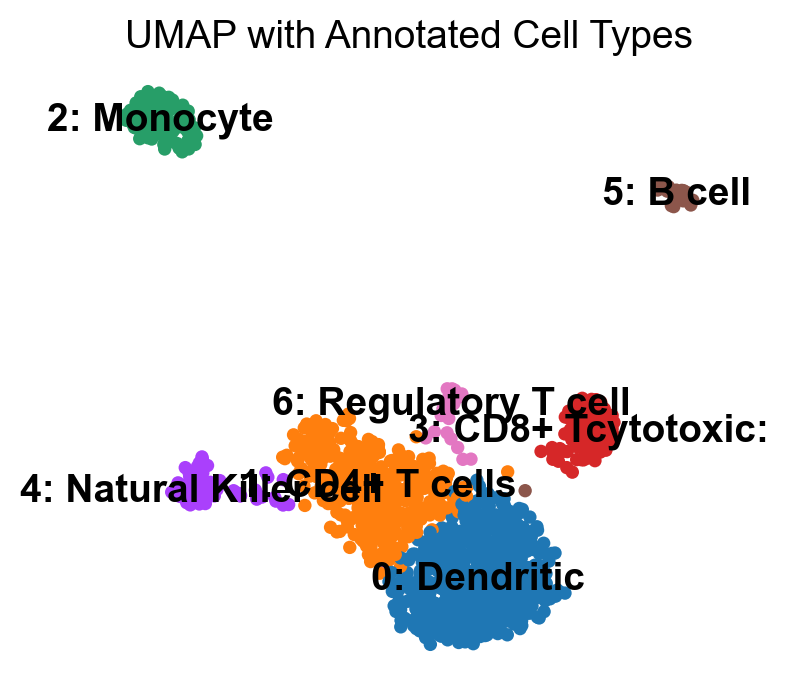

Marker gene finding and cluster annotation complete (review plots and manual names).


In [9]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', rankby_abs=True, tie_correct=True)

# Diagnostic: Print the actual categories
print("\nDiagnostic: Actual Leiden Cluster Categories")
actual_leiden_categories = adata.obs['leiden'].cat.categories.tolist()
print(f"Actual Leiden clusters are: {actual_leiden_categories}")
print("End Diagnostic")

new_cluster_names = [  
    "0: Dendritic",  
    "1: CD4+ T cells",
    "2: Monocyte",
    "3: CD8+ Tcytotoxic:",
    "4: Natural Killer cell",
    "5: B cell",
    "6: Regulatory T cell"
]
adata.rename_categories('leiden', new_cluster_names) 
sc.pl.umap(adata, color='leiden', legend_loc='on data', save="_umap_annotated.png", title="UMAP with Annotated Cell Types", show=True)
plt.show()
print("Marker gene finding and cluster annotation complete (review plots and manual names).")

In [10]:
adata.write("C:/Users/Admin/Desktop/adata.h5ad")
print("Saved")

Saved
